In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
wget https://raw.githubusercontent.com/guiwitz/BIAPy/master/course_functions.py
pip install aicsimageio
pip install mrc

# 4. Image import/export

We have already seen a quick example of image import. Here, we are going to learn about this in more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

## 4.1 Simple case

Most of the time the simples command imread() will do the job. One has just to specifiy the path of the file or a url. In general your path is going to look something like:
```
image = io.imread('/This/is/a/path/MyData/Klee.jpg')
```

In [2]:
file_path = '/content/drive/My Drive/Data/Klee.jpg'
print(file_path)

/content/drive/My Drive/Data/Klee.jpg


Here we only use a relative path, knowing that the ```Data``` folder is one level above the notebook folder. However you can also give a complete path. We can also check what's the complete path of the current file:

In [3]:
import os
print(os.path.realpath(file_path))

/Users/gw18g940/OneDrive - Universitaet Bern/Courses/BiaPy/Data/Klee.jpg


Now we can import the image:

In [4]:
image = io.imread(file_path)

In [5]:
image.shape

(584, 756, 3)

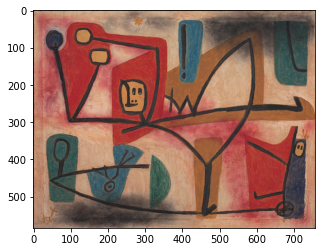

In [6]:
plt.imshow(image);

Now with a url:

In [7]:
image = io.imread('https://upload.wikimedia.org/wikipedia/commons/0/09/FluorescentCells.jpg')

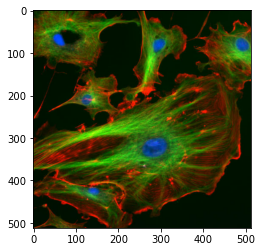

In [8]:
plt.imshow(image)
plt.show()

## 4.2 Series of images (.tif)

Popular compressed formats such as jpg are usually used for natural images e.g. in facial recognition. The reason for that is that for those applications, in most situations one does not care about quantitative information and effects of information compression occurring in jpg are irrelevant. Also, those kind of data are rarely multi-dimensional (except for RGB).

In most other cases, the actual pixel intensity gives important information and one needs a format that preserves that information. Usually this is the .tif format or one of its many derivatives and we are focusing throughout this course on this format.

Very often data contain multiple levels of information e.g. channels, time-lapses etc. There are two ways of storing that information: as separate single-plane tif files or as large multi-dimensional tif files.

### 4.2.1 Series of separate images

In the first case, you would have multiple single .tif files within one folder. In that case, the file name usually contains indications about the content of the image, e.g a time point or a channel. The general way of dealing with this kind of situation is to use regular expressions, a powerful tool to parse information in text. This can be done in Python using the ```re``` module.

Here we will use an approach that identifies much simpler patterns.

Let's first see what files are contained within a folder of a microscopy experiment containing images acquired at two wavelengths using the ```os``` module:

In [9]:
import os

In [10]:
folder = '/content/drive/My Drive/Data/BBBC007_v1_images/A9'

Let's list all the files contained in the folder

In [11]:
files = os.listdir(folder)
print(files)

['A9 p10d.tif', 'A9 p10f.tif', 'A9 p7d.tif', 'A9 p7f.tif', 'A9 p9f.tif', 'A9 p5d.tif', 'A9 p5f.tif', 'A9 p9d.tif']


The two channels are defined by the last character before .tif. Using the wild-card sign * we can define a pattern to select only the 'd' channel: *d.tif. We complete that name with the correct path. Now we use the native Python module ```glob``` to parse the folder content using this pattern:

In [12]:
import glob

In [13]:
d_channel = glob.glob(folder+'/*d.tif')
d_channel

['/content/drive/My Drive/Data/BBBC007_v1_images/A9/A9 p10d.tif',
 '/content/drive/My Drive/Data/BBBC007_v1_images/A9/A9 p7d.tif',
 '/content/drive/My Drive/Data/BBBC007_v1_images/A9/A9 p5d.tif',
 '/content/drive/My Drive/Data/BBBC007_v1_images/A9/A9 p9d.tif']

Then we use again the ```imread()``` function to import a specific file:

In [14]:
image1 = io.imread(d_channel[0])

In [15]:
image1.shape

(450, 450)

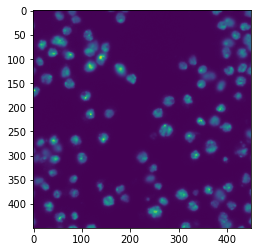

In [16]:
plt.imshow(image1);

These two steps can in principle be done in one step using the ```imread_collection()``` function of skimage.

We can also import all images and put them in list if we have sufficient memory:

In [17]:
channel1_list = []
for x in d_channel:
    temp_im = io.imread(x)
    channel1_list.append(temp_im)

Or better:

In [18]:
channel1_list = [io.imread(x) for x in d_channel]

Let's see what we have in that list of images by plotting them:

In [19]:
channel1_list[0].shape

(450, 450)

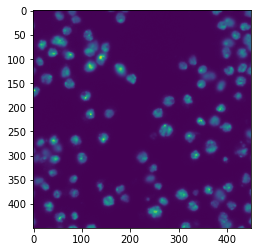

In [20]:
plt.imshow(channel1_list[0]);

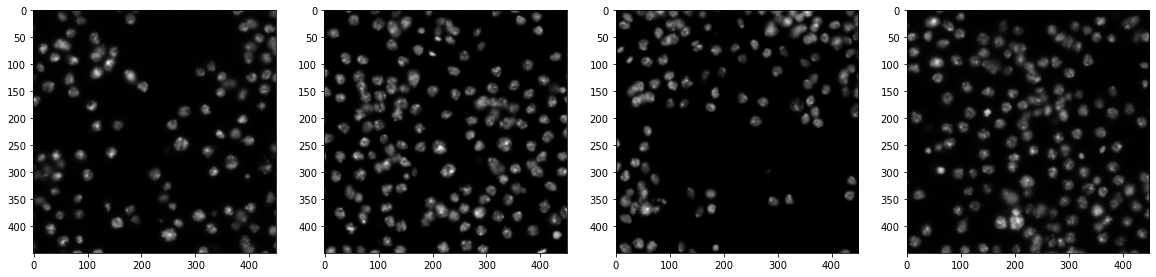

In [21]:
num_plots = len(channel1_list)
fig, ax = plt.subplots(1,num_plots, figsize=(20,30))
for i in range(num_plots):
    ax[i].imshow(channel1_list[i],cmap = 'gray')

scikit-image offers an out-of-the box solutions for such cases. You can simply import a series of images using:

In [22]:
mycollection = io.ImageCollection(folder+'/*d.tif')

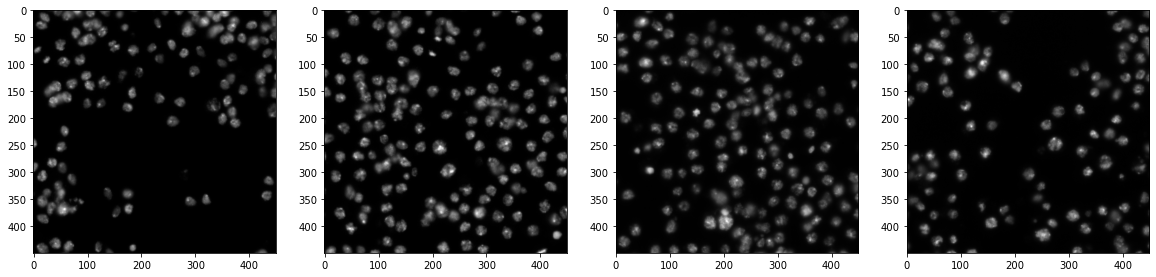

In [23]:
num_plots = len(mycollection)
fig, ax = plt.subplots(1,num_plots, figsize=(20,30))
for i in range(num_plots):
    ax[i].imshow(mycollection[i],cmap = 'gray')

### 4.2.2 Multi-dimensional stacks via skimage

We now look at a more complex multi-dimensional case taken from a public dataset (J Cell Biol. 2010 Jan 11;188(1):49-68) that can be found [here](http://flagella.crbs.ucsd.edu/images/30567). It is already provided it in the Data folder:

In [24]:
file = '/content/drive/My Drive/Data/30567/30567.tif'

The dataset is a time-lapse 3D confocal microscopy acquired in two channels, one showing the location of tubulin, the other of lamin (cell nuclei).

All .tif variants have the same basic structure: single image planes are stored in individual "sub-directories" within the file. Some meta information is stored with each plane, some is stored for the entire file. However, how the different dimensions are ordered within the file (e.g. all time-points of a given channel first, or alternatively all channels of a given time-point) can vary wildly, and thus image import might have different outcomes. The simplest we can do is to just try to import the dataset with the ```imread()``` function:

In [25]:
image = io.imread(file)

In [26]:
image.shape

(72, 2, 5, 512, 672)

From the reference, we know that we are supposed to have 72 time-points, 2 channels, 5 z-stacks, so the importer did a good job at creating a mulit-dimensional numpy array. One of the drawbacks of this approach is that it's not usable for very large datasets as all data are loaded into RAM.

Using slicing, we look at the first time point, of both channels, of the first plane, and we indeed get an appropriate result:

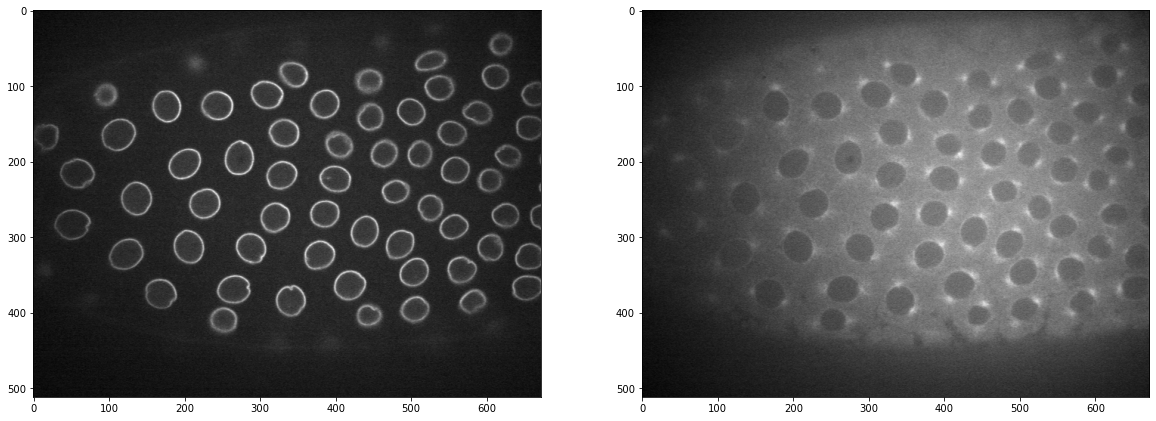

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(image[0,0,0,:,:],cmap = 'gray')
ax[1].imshow(image[0,1,0,:,:],cmap = 'gray');

Now that we have a Numpy array, we can do the various operations on arrays that we learned about previously. For example, knowing that z is the third dimension (index = 2) we can do a z-projection on that axis for a given channel (0) and time point (0). Note that since we fix the two first dimensions, our array is reduced to a 3D array and we project along what is now the 1st dimension:

In [28]:
image[0,0,:,:,:].shape

(5, 512, 672)

In [29]:
maxproj = np.max(image[0,0,:,:,:],axis = 0)
maxproj.shape

(512, 672)

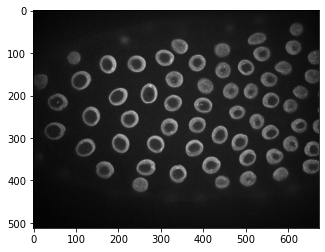

In [30]:
plt.imshow(maxproj,cmap = 'gray');

skimage also allows one to use specific import plug-ins for various applications (e.g. gdal for geographic data, FITS for astronomy etc.). See [here](https://scikit-image.org/docs/dev/api/skimage.io.html) for more details.

In addition, one can have access to a lower level reader in particular for tiff files. It is accessible through the MultiImage object of the skimage.io module:

In [31]:
data = io.MultiImage(file)

The advantage of this approach is that, using the default options, the reader doesn't load the full dataset into RAM but only parses the content of the file. The length of ```data``` indicates the number of images found in the file:

In [32]:
len(data)

720

We see that this matches what we obtained before with the standard image reader which had $72 x 5 x 2 = 720$ images.

Then we can actually load a single plane with:

In [33]:
data[0]

array([[3598, 3341, 3341, ..., 3341, 3855, 3855],
       [3855, 3598, 3855, ..., 3341, 3598, 3855],
       [3855, 3598, 3598, ..., 3855, 4112, 3855],
       ...,
       [3855, 3341, 3341, ..., 4112, 3598, 3855],
       [3855, 3598, 3855, ..., 4112, 4112, 3855],
       [3855, 3855, 3598, ..., 3855, 3855, 4112]], dtype=uint16)

This loads only the first plane of the stack. The following ones are loaded by using indices 1-719. We can visually verify that we indeed load image planes:

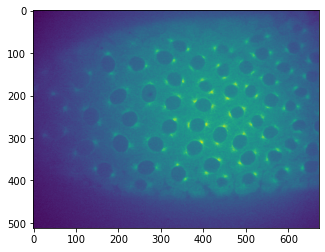

In [34]:
plt.imshow(data[6])
plt.show()

### Multi-dimensional stacks via other importers

skimage is not designed to parse metadata, but gives a low-level access to the data. If you are using data that have some standardized metadata you can attempt to use other importers that will parse that information. For example in the example above ```MultiImage``` just gave us a list of images, but no info on the dimensions. We show here how to use the package [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio) (from the Allen Institute for Cell Science) which gives access to the metadata, as well many other features not demonstrated here.

Just like before we start by importing the reader *object* and then use it to read data:

In [35]:
from aicsimageio import AICSImage

In [36]:
data_aics = AICSImage('/content/drive/My Drive/Data/30567/30567.tif')

Now we have access to a long list of metadata. For example the order of the dimensions:

In [37]:
data_aics.dims

'STCZYX'

Or the size of each dimension, for example time or z-stacks:

In [38]:
data_aics.size_t

72

In [39]:
data_aics.size_z

5

Finally, we can access the actualy data, and in particular specify sub-stacks:

In [40]:
substack_channel0 = data_aics.get_image_data("ZYX", C=0, T=0) 
substack_channel1 = data_aics.get_image_data("ZYX", C=1, T=0) 

In [41]:
substack_channel0.shape

(5, 512, 672)

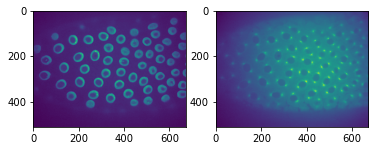

In [42]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(substack_channel0.max(axis = 0))
ax[1].imshow(substack_channel1.max(axis = 0));

### 4.2.3 Alternative formats

While a large majority of image formats is somehow based on tif, instrument providers often make their own tif version by creating a proprietary format. This is for example the case of the Zeiss microscopes with .lsm or .czi formats. Some of those files can still be read by ```skimage.io.imread()``` albeit using a specific reader to make sure the data are read properly. Let's try for example to open the following [file](https://zenodo.org/record/3594412#.Xme_eJP0lTY) from Zenodo:

In [43]:
image = io.imread('/content/drive/My Drive/Data/hsp-17 translational tail z-stack raw.lsm')
image.shape

(2, 1024, 1024)

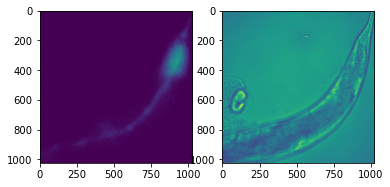

In [44]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image[0,:,:])
ax[1].imshow(image[1,:,:]);

It looks like we only have a single plane of two channels. However, as the file name indicates, we expect to have a z-stack. The default importer did not manage to properly read the .lsm metadata and failed to import all files. We can fix this by using a specific ```plugin``` to read the file. In a large number of cases this is going to be ```tifffile``` (based on [this work](https://pypi.org/project/tifffile/)).

In [45]:
image = io.imread('/content/drive/My Drive/Data/hsp-17 translational tail z-stack raw.lsm', plugin = 'tifffile')

In [46]:
image.shape

(1, 64, 2, 1024, 1024)

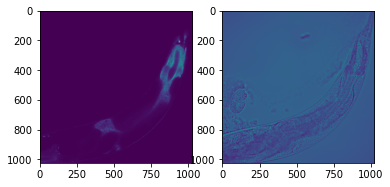

In [47]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image[0,30,0,:,:])
ax[1].imshow(image[0,30,1,:,:]);

For more "exotic" cases, you will need to find a specific package capable of importing your file format however it is extremely rare that no reader already exists. Here we open for example an DeltaVision file for which a reader is available [here](https://pypi.org/project/mrc/).

In [48]:
import mrc

In [49]:
mrcimage = mrc.imread('/content/drive/My Drive/Data/HeLa_H2B-PAGFP_01_12_R3D_D3D.dv')

In [50]:
mrcimage.shape

(2, 43, 1, 1024, 1024)

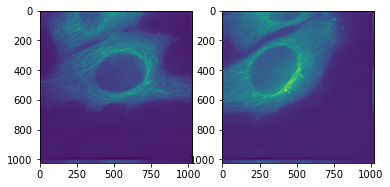

In [51]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(mrcimage[0,1,0,:,:])
ax[1].imshow(mrcimage[0,30,0,:,:]);

## 4.3 Exporting images

There are two ways to save images. Either as plain matrices, which can be written and re-loaded very fast, or as actual images.

Just like for loading, saving single planes is easy. Let us save a small region of one of the images above:

In [52]:
image[0].shape

(64, 2, 1024, 1024)

In [53]:
io.imsave('/content/drive/My Drive/Data/regionb.tif',mrcimage, plugin='tifffile')


/Users/gw18g940/miniconda3/envs/biapy/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: /content/drive/My Drive/Data/regionb.tif is a low contrast image
  """Entry point for launching an IPython kernel.


In [54]:
io.imsave('/content/drive/My Drive/Data/region.tif',mrcimage[0,0,0,200:300,200:300], plugin='tifffile')
io.imsave('/content/drive/My Drive/Data/region.jpg',mrcimage[0,0,0,200:300,200:300], plugin='tifffile')

/Users/gw18g940/miniconda3/envs/biapy/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: /content/drive/My Drive/Data/region.tif is a low contrast image
  """Entry point for launching an IPython kernel.
/Users/gw18g940/miniconda3/envs/biapy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: /content/drive/My Drive/Data/region.jpg is a low contrast image
  


In [55]:
reload_im = io.imread('/content/drive/My Drive/Data/region.jpg')

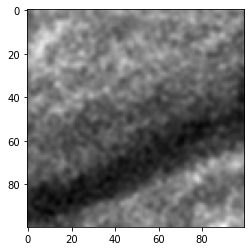

In [56]:
plt.imshow(reload_im,cmap='gray')
plt.show()

Saving multi-dimensional .tif files is a bit more complicated as one has of course to be careful with the dimension order. Here's an example of how to save a dataset with two time poins, 5 stacks, 3 channels into a file that can then be opened as a hyper-stack in Fiji:

In [57]:
data = np.random.rand(2, 5, 3, 301, 219)#generate random images
data = (data*100).astype(np.uint8)#transform data in a reasonable 8bit range

In [58]:
io.imsave('/content/drive/My Drive/Data/multiD_set.tif', data, plugin='tifffile', bigtiff=False, imagej=True)

When opened in Fiji, the stack is correctly interpreted:

<img src="illustrations/fiji_multiD.png" alt="" style="width: 30%"/>

## 4.4 Interactive plotting

Jupyter offers a solution to interact with various types of plots: ipywidget

In [59]:
from ipywidgets import interact, IntSlider

The interact() function takes as input a function and a value for that function. That function should plot or print some information. interact() then creates a widget, typically a slider, executes the plotting function and adjusts the ouptut when the slider is moving. For example:

In [60]:
def square(num=1):
    print(str(num)+' squared is: '+str(num*num))

In [61]:
square(3)

3 squared is: 9


In [62]:
interact(square, num=(0,20,1));

interactive(children=(IntSlider(value=1, description='num', max=20), Output()), _dom_classes=('widget-interact…

Depending on the values passed as arugments, interact() will create different widgets. E.g. with text:

In [63]:
def f(x): 
    return x
interact(f, x='Hi there!');

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

An important note for our imaging topic: when moving the slider, the function is continuously updated. If the function does some computationally intensitve work, this might just overload the system. To avoid that, one can explicitly specifiy the slider type and its specificities:

In [64]:
def square(num=1):
    print(str(num)+' squared is: '+str(num*num))
interact(square, num = IntSlider(min=-10,max=30,step=1,value=10,continuous_update = False));

interactive(children=(IntSlider(value=10, continuous_update=False, description='num', max=30, min=-10), Output…

If we want to scroll through our image stack we can do just that. Let's first define a function that will plot the first plane of the channel 1 at all time points:

In [65]:
image = io.imread(file)

In [66]:
def plot_plane(t):
    plt.imshow(image[t,0,0,:,:])
    plt.show()

In [67]:
interact(plot_plane, t = IntSlider(min=0,max=71,step=1,value=0,continuous_update = False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=71), Output()), _dom_cl…

Of course we can do that for multiple dimensions:

In [68]:
def plot_plane(t,c,z):
    plt.imshow(image[t,c,z,:,:])
    plt.show()

interact(plot_plane, t = IntSlider(min=0,max=71,step=1,value=0,continuous_update = True),
         c = IntSlider(min=0,max=1,step=1,value=0,continuous_update = True),
         z = IntSlider(min=0,max=4,step=1,value=0,continuous_update = True));

interactive(children=(IntSlider(value=0, description='t', max=71), IntSlider(value=0, description='c', max=1),…

And we can make it as fancy as we want:

In [69]:
def plot_plane(t,c,z):
    if c == 0:
        plt.imshow(image[t,c,z,:,:], cmap = 'Reds')
    else:
        plt.imshow(image[t,c,z,:,:], cmap = 'Blues')
    plt.show()

interact(plot_plane, t = IntSlider(min=0,max=71,step=1,value=0,continuous_update = True),
         c = IntSlider(min=0,max=1,step=1,value=0,continuous_update = True),
         z = IntSlider(min=0,max=4,step=1,value=0,continuous_update = True));

interactive(children=(IntSlider(value=0, description='t', max=71), IntSlider(value=0, description='c', max=1),…